This is a preliminary data analysis for the Kaggle M5 contest. 

[Link to contest](https://www.kaggle.com/c/m5-forecasting-accuracy/leaderboard) 

[More details about the contest](https://mofc.unic.ac.cy/m5-competition/) 

In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

%matplotlib inline


There are 4 data files that can be downloaded

- calendar.csv : information about the dates when the products were sold 
- sales_train_validation.csv : information about how many sales there were from d_1 to d_1913
- sample_submission.csv : example submission file 
- sell_prices.csv : information on how much each product was sold 

It appears that Kaggle also recently released one more csv file called "sales_train_evaluation.csv" recently. This contains the sales from d_1914 to d_1941. We can predict the sales for the 28 day window (d_1914 to d_1941) and compare it with the values in sales_train_evaluation.csv for **validation**. Afterwards, we need to predict the sales from d_1942 to d_1969 and we will be graded on our prediction for these 28 days on the Kaggle private leaderboard. The public leaderboard will be scored based on the validation set. 

The sales_train_evaluation.csv will be released **June 1st**. 

In [30]:
df_train = pd.read_csv("sales_train_validation.csv")
df_sell = pd.read_csv("sell_prices.csv")
df_calendar = pd.read_csv("calendar.csv")
sub = pd.read_csv("sample_submission.csv")


Information was collected from 3 states (CA, WI, TX). Let us look at some other stats

In [32]:
print("Unit sales of all products, aggregated for each state", df_train['state_id'].nunique())
print("Unit sales of all products, aggregated for each store", df_train['store_id'].nunique())
print("Unit sales of all products, aggregated for each category", df_train['cat_id'].nunique())
print("Unit sales of all products, aggregated for each department", df_train['dept_id'].nunique())
print("Unit sales of all products, aggregated for each State and category", df_train['state_id'].nunique() * df_train['cat_id'].nunique())
print("Unit sales of all products, aggregated for each State and department", df_train['state_id'].nunique() * df_train['dept_id'].nunique())
print("Unit sales of all products, aggregated for each store and category", df_train['store_id'].nunique() * df_train['cat_id'].nunique())
print("Unit sales of all products, aggregated for each store and department", df_train['store_id'].nunique() * df_train['dept_id'].nunique())
print("Unit sales of all products, aggregated for each  and category", df_train['dept_id'].nunique() * df_train['cat_id'].nunique())
print("Unit sales of product x, aggregated for all stores/states", df_train['item_id'].nunique())
print("Unit sales of product x, aggregated for all states", df_train['item_id'].nunique() * df_train['state_id'].nunique())
print("Unit sales of product x, aggregated for all stores", df_train['item_id'].nunique() * df_train['store_id'].nunique())



Unit sales of all products, aggregated for each state 3
Unit sales of all products, aggregated for each store 10
Unit sales of all products, aggregated for each category 3
Unit sales of all products, aggregated for each department 7
Unit sales of all products, aggregated for each State and category 9
Unit sales of all products, aggregated for each State and department 21
Unit sales of all products, aggregated for each store and category 30
Unit sales of all products, aggregated for each store and department 70
Unit sales of all products, aggregated for each  and category 21
Unit sales of product x, aggregated for all stores/states 3049
Unit sales of product x, aggregated for all states 9147
Unit sales of product x, aggregated for all stores 30490


We will now examine the dataframes one by one. First let's start with calendar.csv

# Looking at calendar.csv

In [33]:
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


- date: “y-m-d” formatted date 
- wm_yr_wk: ID for the week the specified date belongs to  
- weekday: literally the day of the week 
- wday: ID of the weekday, where Sat = 1, Sun = 2, Mon = 3, Tue = 4, etc
- month: the month of the date 
- year: the year of the date 
- event_name_1: If there is some event related to this date, an event name is specified. 
- event_type_1: If there is some event related to this date, an event type is specified. 
- event_name_2: If there is another event related to this date, an event name is specified. 
- event_type_2: If there is another event related to this date, an event type is specified. 
- snap_CA, snap_TX, and snap_WI: Indicates whether the store in CA, TX and WI allows [SNAP](http://www.gettingfoodstamps.org/whatissnap.html) purchases on the given date. If 1 then it allows SNAP and if 0 it does not (so it is a binary encoded data). 

Let us see some examples of non-NA event names and types. As we can see below, some of the events are SuperBowls or National Holidays. We can also see the count of different events below

In [36]:
df_calendar[df_calendar['event_name_1'].notnull()].head()


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1
23,2011-02-21,11104,Monday,3,2,2011,d_24,PresidentsDay,National,NaN,NaN,0,0,0
39,2011-03-09,11106,Wednesday,5,3,2011,d_40,LentStart,Religious,NaN,NaN,1,1,1
46,2011-03-16,11107,Wednesday,5,3,2011,d_47,LentWeek2,Religious,NaN,NaN,0,0,0


Text(0, 0.5, 'Event Name')

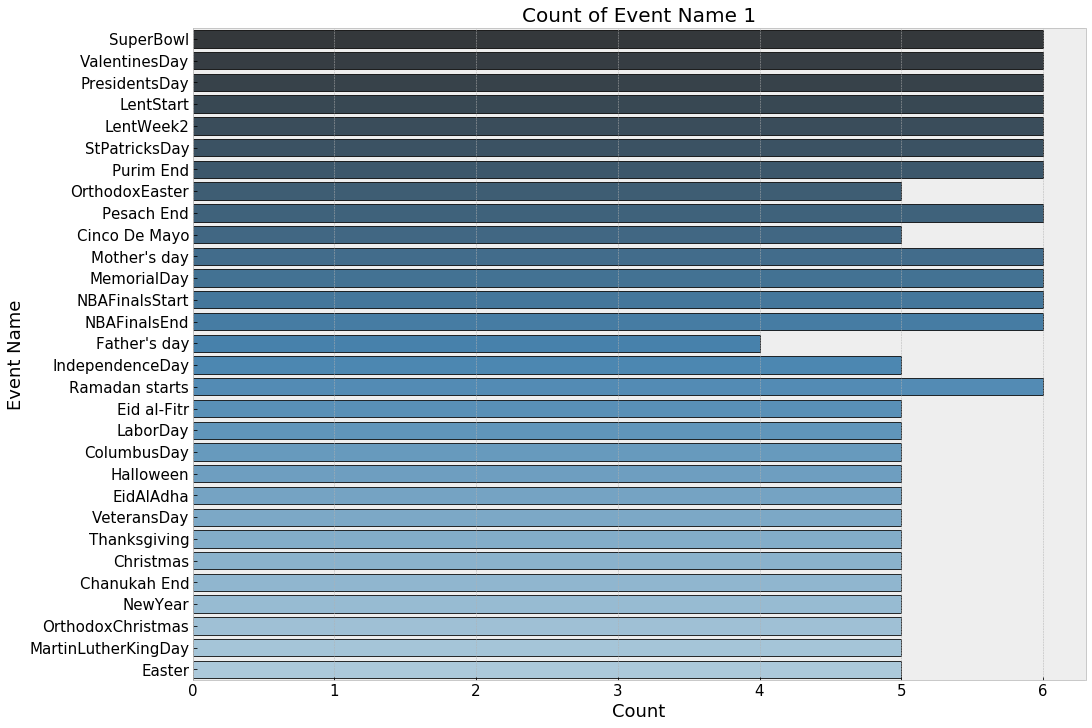

In [40]:
f, ax = plt.subplots(figsize = (16, 12))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_name_1", data = df_calendar, ax = ax, palette = "Blues_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Name 1", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Name", size = 18)

We can also visualize the count of event types 

Text(0, 0.5, 'Event Type')

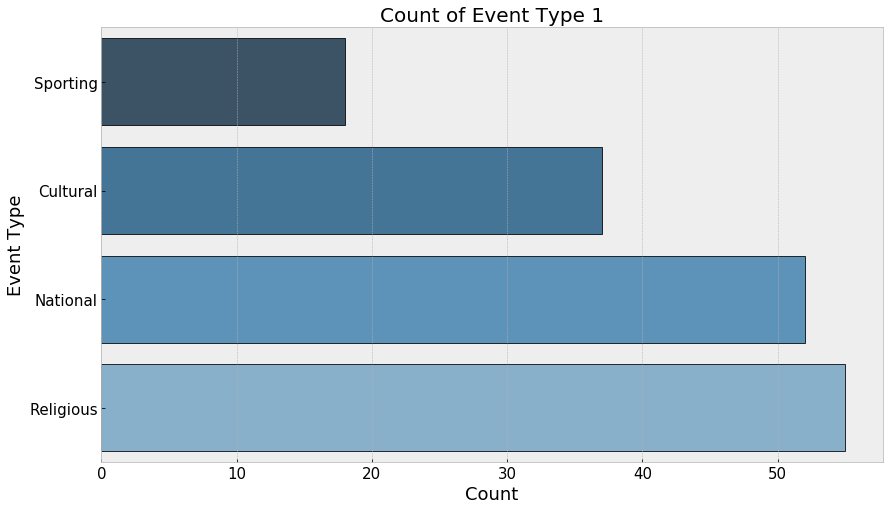

In [41]:
f, ax = plt.subplots(figsize = (14, 8))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_type_1", data = df_calendar, ax = ax, palette = "Blues_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Type 1", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Type", size = 18)


Also, as expected, we can see that rows that have event_name_2 also have event_name_1. 

In [42]:
df_calendar[df_calendar['event_name_2'].notnull()].head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
85,2011-04-24,11113,Sunday,2,4,2011,d_86,OrthodoxEaster,Religious,Easter,Cultural,0,0,0
827,2013-05-05,11315,Sunday,2,5,2013,d_828,OrthodoxEaster,Religious,Cinco De Mayo,Cultural,1,1,1
1177,2014-04-20,11412,Sunday,2,4,2014,d_1178,Easter,Cultural,OrthodoxEaster,Religious,0,0,0
1233,2014-06-15,11420,Sunday,2,6,2014,d_1234,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [43]:
print("event_name_2 notnull shape : ", df_calendar[df_calendar['event_name_2'].notnull()].shape)
print("event_name_1 and 2 notnull shape : ", df_calendar[(df_calendar['event_name_2'].notnull()) & (df_calendar['event_name_1'].notnull())].shape)


event_name_2 notnull shape :  (5, 14)
event_name_1 and 2 notnull shape :  (5, 14)


Let us examine the counts for event_name_2 and event_type_2.  

Text(0, 0.5, 'Event Name')

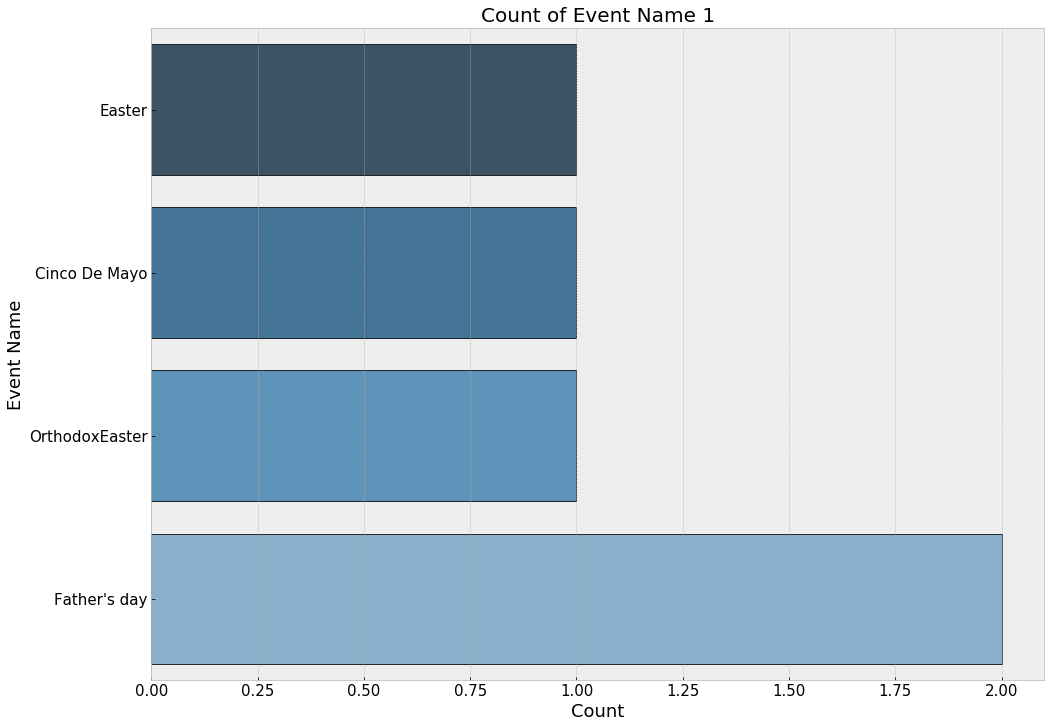

In [44]:
f, ax = plt.subplots(figsize = (16, 12))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_name_2", data = df_calendar, ax = ax, palette = "Blues_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Name 1", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Name", size = 18)

Text(0, 0.5, 'Event Name')

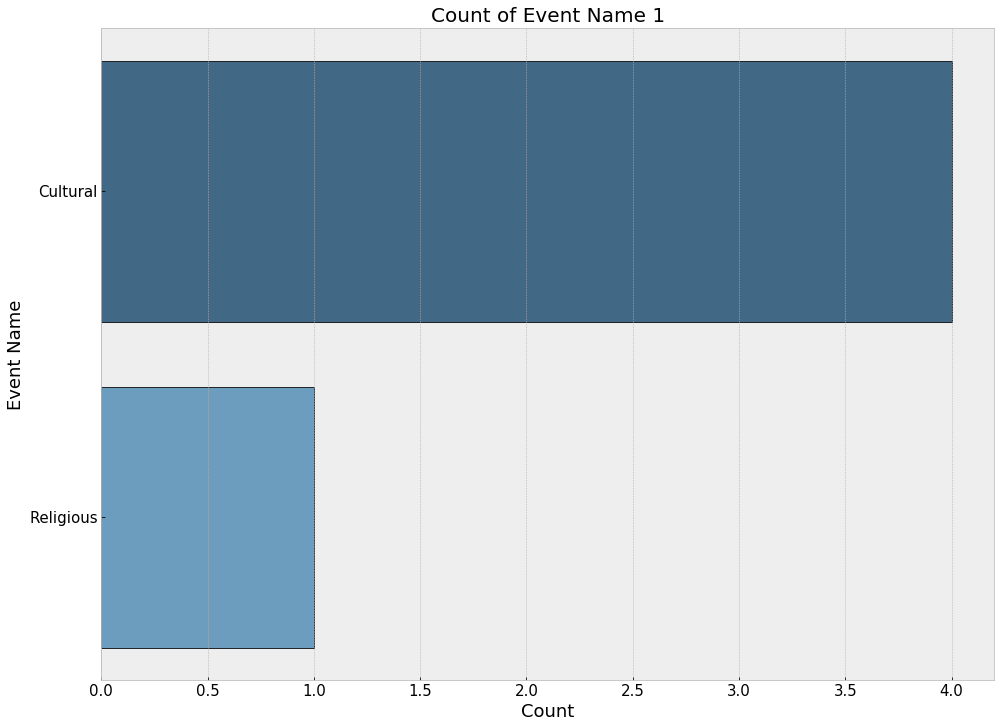

In [45]:
f, ax = plt.subplots(figsize = (16, 12))
ax.grid(axis='x', linestyle='--')

sns.countplot(y = "event_type_2", data = df_calendar, ax = ax, palette = "Blues_d",edgecolor='black', linewidth=0.8)
plt.title("Count of Event Name 1", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Count", size = 18)
plt.ylabel("Event Name", size = 18)

We don't have as much variety in event names and types for event_name_2 and event_type_2. 

# Looking at sell_price.csv

- store_id: ID of the store that sells the product 
- item_id: ID of the product 
- wm_yr_wk: ID of that particular week 
- sell_price: The average (sell) price of the product for a week. 

In [46]:
df_sell.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [57]:
df_sell.shape

(6841121, 4)

In [58]:
df_sell['item_id'].nunique()

3049

In [47]:
df_sell["sell_price"].isnull().sum()

0

We see that all the values of the sell_prices are not null. Let us try plotting the change in (average weekly) price for one of the items, namely HOBBIES_1_001.  

In [56]:
y_sell_prices = df_sell['sell_price'].loc[(df_sell['item_id'] == 'HOBBIES_1_001')]
y_sell_prices

0          9.58
1          9.58
2          8.26
3          8.26
4          8.26
           ... 
6145173    8.38
6145174    8.38
6145175    8.38
6145176    8.38
6145177    8.38
Name: sell_price, Length: 1528, dtype: float64

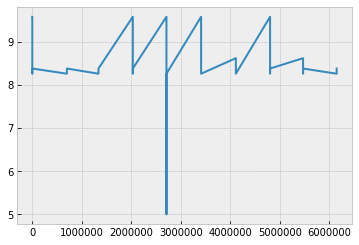

In [55]:
plt.plot(y_sell_prices) 
plt.show()

As we can see the average weekly price is not always constant.  

# Looking at sales_train.csv

In [60]:
df_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


- item_id: product ID 
- dept_id: the ID of the department where this product belongs 
- cat_id: the categorical ID of the product   
- store_id: the ID of the store where the product is being sold 
- state_id: the state ID of where the store is located 
- d_1, d_2, …, d_i, … d_1941: the unit sales count for days d_1 to d_1941 

In [63]:
df_train.shape

(30490, 1919)

We have 30490 training data in total. 

In [61]:
df_train["cat_id"].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

We see that all products belong to either of the three categories, hobbies, household and foods. 

In [62]:
df_train["dept_id"].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

# Looking at sample submission 

In [64]:
sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This is simply how our submission file should look like. 

In [94]:
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


When we look at the full shape, we see that there are 60980 rows (this is two times the number of rows of the train data). This is because the first 30490 (=60980/2) rows are the predictions for the next 28 days (d_1914-d_1941) and the second 30490 rows is the prediction for the next 28 days (d_1942-d_1969). 

# Rudimentary Time Series Analysis

We first get the data for all columns starting with d_

In [66]:
d_cols = [c for c in df_train.columns if 'd_' in c] 

According to many notebooks, FOODS_3_090_CA_3_validation was the most frequently sold product, so we will try to do some analysis with this product. 

In [72]:
df_item = df_train.loc[df_train['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T 
df_item

,8412
d_1,108
d_2,132
d_3,102
d_4,120
d_5,106
...,...
d_1909,88
d_1910,77
d_1911,141
d_1912,139


In [73]:
df_item = df_item.rename(columns = {8412:"FOODS_3_090_CA_3"})
df_item

,FOODS_3_090_CA_3
d_1,108
d_2,132
d_3,102
d_4,120
d_5,106
...,...
d_1909,88
d_1910,77
d_1911,141
d_1912,139


In [74]:
df_item = df_item.reset_index().rename(columns={'index': 'd'})
df_item

,d,FOODS_3_090_CA_3
0,d_1,108
1,d_2,132
2,d_3,102
3,d_4,120
4,d_5,106
...,...,...
1908,d_1909,88
1909,d_1910,77
1910,d_1911,141
1911,d_1912,139


Let's merge df_item with df_calendar

In [75]:
df_item = df_item.merge(df_calendar, how='left', validate='1:1')

In [76]:
df_item

,d,FOODS_3_090_CA_3,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,108,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,132,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,102,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,120,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,106,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,88,2016-04-20,11612,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,d_1910,77,2016-04-21,11612,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,d_1911,141,2016-04-22,11612,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,d_1912,139,2016-04-23,11613,Saturday,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


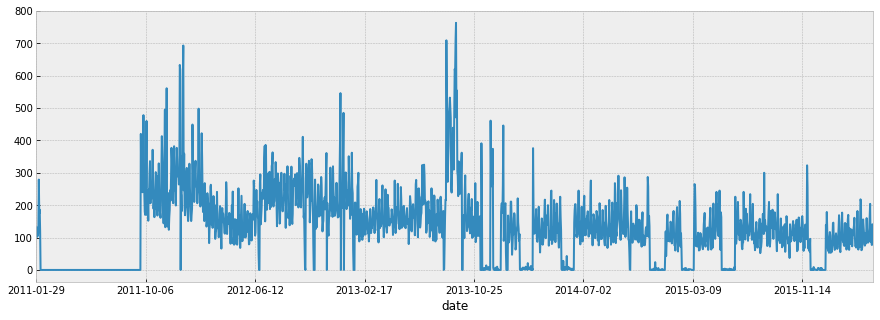

In [77]:
df_item.set_index('date')['FOODS_3_090_CA_3'].plot(figsize=(15, 5), color=next(color_cycle))

An interesting thing about the sales for this product is that there are regions of plateau, probably meaning there were days when this product was not sold at all. 

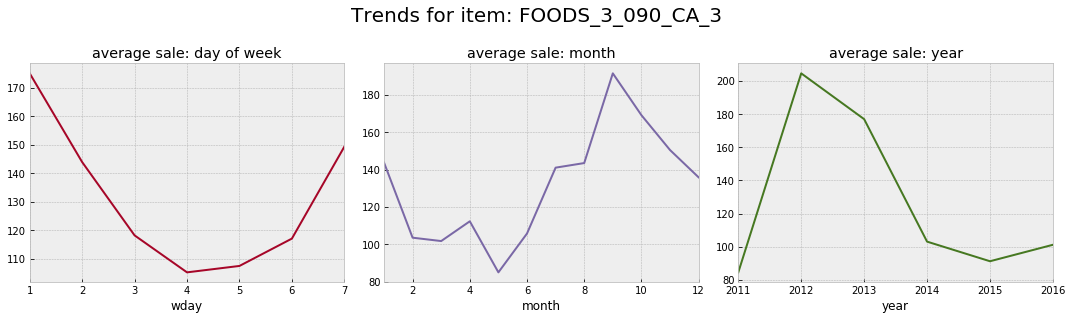

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# daily, monthly and yearly sales respectively 
df_item.groupby('wday').mean()['FOODS_3_090_CA_3'].plot(kind='line', title='average sale: day of week', color=next(color_cycle), ax=ax1)

df_item.groupby('month').mean()['FOODS_3_090_CA_3'].plot(kind='line', title='average sale: month', color=next(color_cycle), ax=ax2)

df_item.groupby('year').mean()['FOODS_3_090_CA_3'].plot(kind='line', title='average sale: year', color=next(color_cycle), ax=ax3)


fig.suptitle('Trends for item: FOODS_3_090_CA_3', size=20, y=1.1)
plt.tight_layout()
plt.show()


We can make a few comments based on this graph. This product seems to sell the most closer to the weekend (Friday/Saturday) and this product is very popular during summer (July all the way to September). Also we see that its sales has been gradually decreasing since 2012. 

# Sales by category

In [81]:
item_id_split = df_sell['item_id'].str.split('_', expand=True)
item_id_split[0].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

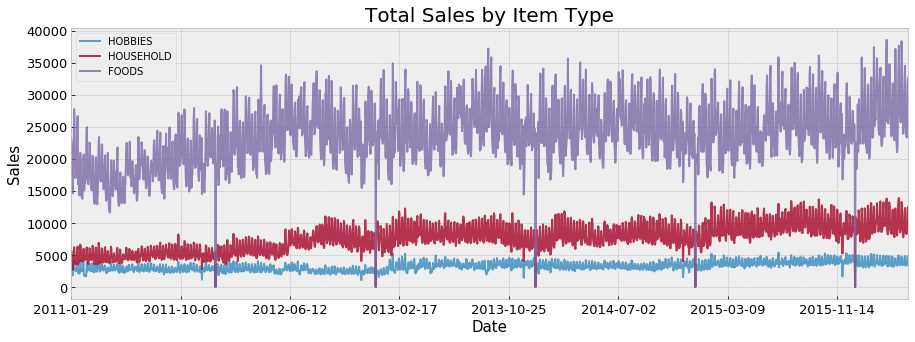

In [82]:
past_sales = df_train.set_index('id')[d_cols].T.merge(df_calendar.set_index('d')['date'], left_index=True, right_index=True, validate='1:1').set_index('date')

item_type_list = item_id_split[0].unique()

for i in item_type_list:
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5), alpha=0.8)

plt.title('Total Sales by Item Type', size = 20)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.xlabel("Date", size = 15)
plt.ylabel("Sales", size = 15)
plt.legend(item_type_list)
plt.show()

The food category has the greates sales. 

# Sales by Store

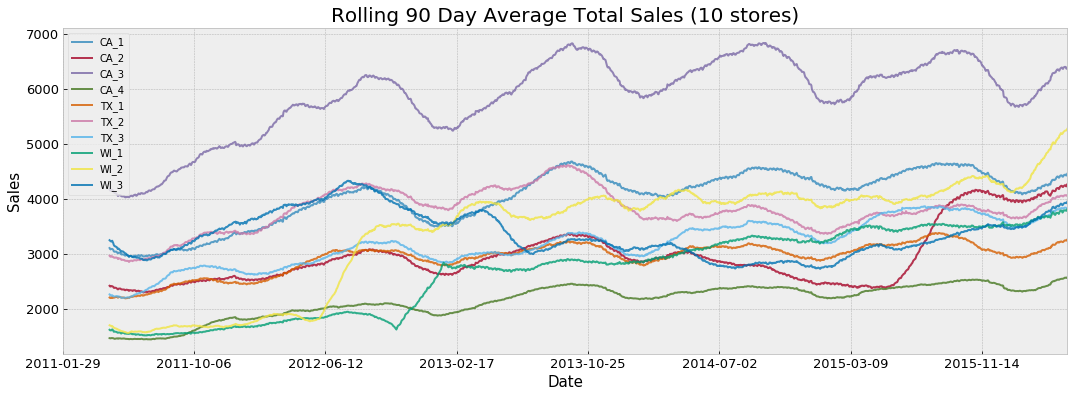

In [83]:
store_list = df_sell['store_id'].unique()

for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items].sum(axis=1).rolling(90).mean().plot(figsize=(18, 6), alpha=0.8)

    
plt.title('Rolling 90 Day Average Total Sales (10 stores)', size = 20)
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.xlabel("Date", size = 15)
plt.ylabel("Sales", size = 15)    
plt.legend(store_list)
plt.show()

The store CA3 has the most sales. 

# Example Submission using Moving Average

In [85]:
days = range(1, 1913 + 1) 
time_series_columns = [f'd_{i}' for i in days]
#time_series_columns

In [87]:
time_series_columns[:10]

['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10']

In [89]:
time_series_data = df_train[time_series_columns]

time_series_data

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,...,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,...,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


In [102]:
# checking for 50 day moving average for first product 
np.mean(time_series_data.loc[0][-50:])

1.02

Let's try a 50-day moving average

In [90]:
MA_x = 50

forecast = time_series_data.iloc[:, -MA_x:].copy()
for i in range(28):
    forecast['F'+str(i+1)] = forecast.iloc[:, -MA_x:].mean(axis=1)    
    
forecast = forecast[['F'+str(i+1) for i in range(28)]]
forecast


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,1.02,1.0204,1.040808,1.061624,1.062857,1.064114,1.025396,1.045904,1.066822,1.088158,1.089922,1.091720,1.093554,1.055426,1.056534,1.017665,1.018018,0.998378,0.978346,0.997913,0.997871,0.997829,0.997785,0.997741,1.017696,1.038050,1.058811,1.079987
1,0.20,0.1840,0.167680,0.171034,0.174454,0.157943,0.161102,0.144324,0.147211,0.150155,0.153158,0.156221,0.159346,0.162533,0.165783,0.169099,0.172481,0.175930,0.179449,0.163038,0.146299,0.129225,0.111809,0.094045,0.095926,0.097845,0.099802,0.101798
2,0.50,0.4900,0.479800,0.449396,0.458384,0.467552,0.476903,0.466441,0.455769,0.464885,0.474183,0.483666,0.493340,0.483206,0.492870,0.502728,0.512782,0.523038,0.533499,0.544169,0.535052,0.525753,0.536268,0.546994,0.557934,0.569092,0.580474,0.592084
3,2.04,1.9808,1.960416,1.979624,2.019217,2.059601,2.100793,2.122809,2.125265,2.107771,2.149926,2.172924,2.156383,2.119511,2.121901,2.144339,2.107226,2.129370,2.111958,2.054197,2.095281,2.017186,1.937530,1.976281,2.015806,2.056122,2.097245,2.079190
4,1.28,1.3056,1.291712,1.297546,1.303497,1.329567,1.296158,1.302082,1.308123,1.294286,1.300171,1.306175,1.332298,1.298944,1.284923,1.270622,1.256034,1.221155,1.225578,1.250089,1.275091,1.300593,1.326605,1.333137,1.359800,1.306996,1.253136,1.278198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0.18,0.1636,0.146872,0.149809,0.132806,0.135462,0.138171,0.140934,0.143753,0.146628,0.149561,0.152552,0.155603,0.158715,0.161889,0.165127,0.168430,0.171798,0.175234,0.178739,0.182314,0.185960,0.189679,0.193473,0.197342,0.201289,0.205315,0.209421
30486,0.18,0.1836,0.187272,0.191017,0.194838,0.198735,0.202709,0.206763,0.210899,0.215117,0.219419,0.223807,0.228284,0.232849,0.237506,0.242256,0.247101,0.252043,0.257084,0.262226,0.267471,0.272820,0.278276,0.283842,0.289519,0.295309,0.301215,0.307240
30487,0.98,0.9596,0.958792,0.957968,0.937127,0.935870,0.894587,0.892479,0.890328,0.908135,0.866298,0.863624,0.860896,0.838114,0.854876,0.871974,0.849413,0.866402,0.883730,0.901404,0.879432,0.897021,0.894961,0.892861,0.910718,0.928932,0.947511,0.966461
30488,1.02,1.0004,1.020408,1.040816,1.061632,1.082865,1.104522,1.106613,1.068745,1.090120,1.051922,1.052961,1.054020,1.055101,1.056203,1.057327,1.058473,1.079643,1.061235,1.062460,1.063709,1.044984,0.985883,0.945601,0.964513,0.983803,1.003479,1.023549


In [91]:
validation_ids = df_train['id'].values
evaluation_ids = [i.replace('validation', 'evaluation') for i in validation_ids]
ids = np.concatenate([validation_ids, evaluation_ids])
predictions = pd.DataFrame(ids, columns=['id'])
forecast = pd.concat([forecast] * 2).reset_index(drop=True)
predictions = pd.concat([predictions, forecast], axis=1)
predictions.to_csv('sample_submission.csv', index=False)


In [93]:
predictions 

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.02,1.0204,1.040808,1.061624,1.062857,1.064114,1.025396,1.045904,1.066822,1.088158,1.089922,1.091720,1.093554,1.055426,1.056534,1.017665,1.018018,0.998378,0.978346,0.997913,0.997871,0.997829,0.997785,0.997741,1.017696,1.038050,1.058811,1.079987
1,HOBBIES_1_002_CA_1_validation,0.20,0.1840,0.167680,0.171034,0.174454,0.157943,0.161102,0.144324,0.147211,0.150155,0.153158,0.156221,0.159346,0.162533,0.165783,0.169099,0.172481,0.175930,0.179449,0.163038,0.146299,0.129225,0.111809,0.094045,0.095926,0.097845,0.099802,0.101798
2,HOBBIES_1_003_CA_1_validation,0.50,0.4900,0.479800,0.449396,0.458384,0.467552,0.476903,0.466441,0.455769,0.464885,0.474183,0.483666,0.493340,0.483206,0.492870,0.502728,0.512782,0.523038,0.533499,0.544169,0.535052,0.525753,0.536268,0.546994,0.557934,0.569092,0.580474,0.592084
3,HOBBIES_1_004_CA_1_validation,2.04,1.9808,1.960416,1.979624,2.019217,2.059601,2.100793,2.122809,2.125265,2.107771,2.149926,2.172924,2.156383,2.119511,2.121901,2.144339,2.107226,2.129370,2.111958,2.054197,2.095281,2.017186,1.937530,1.976281,2.015806,2.056122,2.097245,2.079190
4,HOBBIES_1_005_CA_1_validation,1.28,1.3056,1.291712,1.297546,1.303497,1.329567,1.296158,1.302082,1.308123,1.294286,1.300171,1.306175,1.332298,1.298944,1.284923,1.270622,1.256034,1.221155,1.225578,1.250089,1.275091,1.300593,1.326605,1.333137,1.359800,1.306996,1.253136,1.278198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.18,0.1636,0.146872,0.149809,0.132806,0.135462,0.138171,0.140934,0.143753,0.146628,0.149561,0.152552,0.155603,0.158715,0.161889,0.165127,0.168430,0.171798,0.175234,0.178739,0.182314,0.185960,0.189679,0.193473,0.197342,0.201289,0.205315,0.209421
60976,FOODS_3_824_WI_3_evaluation,0.18,0.1836,0.187272,0.191017,0.194838,0.198735,0.202709,0.206763,0.210899,0.215117,0.219419,0.223807,0.228284,0.232849,0.237506,0.242256,0.247101,0.252043,0.257084,0.262226,0.267471,0.272820,0.278276,0.283842,0.289519,0.295309,0.301215,0.307240
60977,FOODS_3_825_WI_3_evaluation,0.98,0.9596,0.958792,0.957968,0.937127,0.935870,0.894587,0.892479,0.890328,0.908135,0.866298,0.863624,0.860896,0.838114,0.854876,0.871974,0.849413,0.866402,0.883730,0.901404,0.879432,0.897021,0.894961,0.892861,0.910718,0.928932,0.947511,0.966461
60978,FOODS_3_826_WI_3_evaluation,1.02,1.0004,1.020408,1.040816,1.061632,1.082865,1.104522,1.106613,1.068745,1.090120,1.051922,1.052961,1.054020,1.055101,1.056203,1.057327,1.058473,1.079643,1.061235,1.062460,1.063709,1.044984,0.985883,0.945601,0.964513,0.983803,1.003479,1.023549
